# Visualize Today's Traffic Accidents in the City of Austin
##### Miguel Novo Villar
##### December, 2022 (More to be added)

## Modules

In [1]:
#Import data science modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Scraping
from sodapy import Socrata

#Time
from datetime import datetime, timedelta

#GEOSPATIAL
import geopandas as gpd
import contextily as cx
#Folium for heatmaps

import folium
from folium import plugins

#Timeseries Analysis
import calendar

#Load Images
from IPython.display import Image

## Retrieve and transform data

##### We need to get data from data.austintexas.gov and autenticate to load the entire dataset

In [2]:
MyAppToken = "MyAppTokenfrom_data.austintexas.gov"

client = Socrata("data.austintexas.gov", #website
                MyAppToken, #token from portal
                 username="mymail@gmail.com", #username
                 password="mypasswords") #password

#Retrieve from the desired repository
results = client.get("dx9v-zd7x", limit = 1000000000)

#Zips
Austin_zips = gpd.read_file("Z:\Clases\CLASE\Master Rochester\Fall_2022\InterviewPrep\ReadAustinData\Zip Code\geo_export_5b8f0432-d113-478a-b2a5-18fba0156b66.shp")[["geoid10", "geometry"]]
Austin_zips.rename(columns = {"geoid10": "ZIP"}, inplace = True)

#Convert to pandas DataFrame, timestamp and sort by date descending
results_df = pd.DataFrame.from_records(results)
results_df["published_date"] = pd.to_datetime(results_df.published_date)
results_df= results_df.sort_values(by="published_date", ascending= False)

print("All time accidents recorded: ", results_df.shape[0])

All time accidents recorded:  303391


# Transform to geopandas

Create geodataframe with accidents from today

In [3]:
today = results_df[(results_df['published_date'] > str(pd.to_datetime(datetime.utcnow() - timedelta(hours=24))))]

gdf = gpd.GeoDataFrame(today, 
                        geometry=gpd.points_from_xy(today.longitude, today.latitude),
                        crs ="EPSG:4326").drop(["location"],axis = 1)
                        # crs ="EPSG:4326").drop(["location","latitude","longitude"],axis = 1)
print("Accidents recorded today: ", today.shape[0])

Accidents recorded today:  113


## Visualize

#### Accidents today

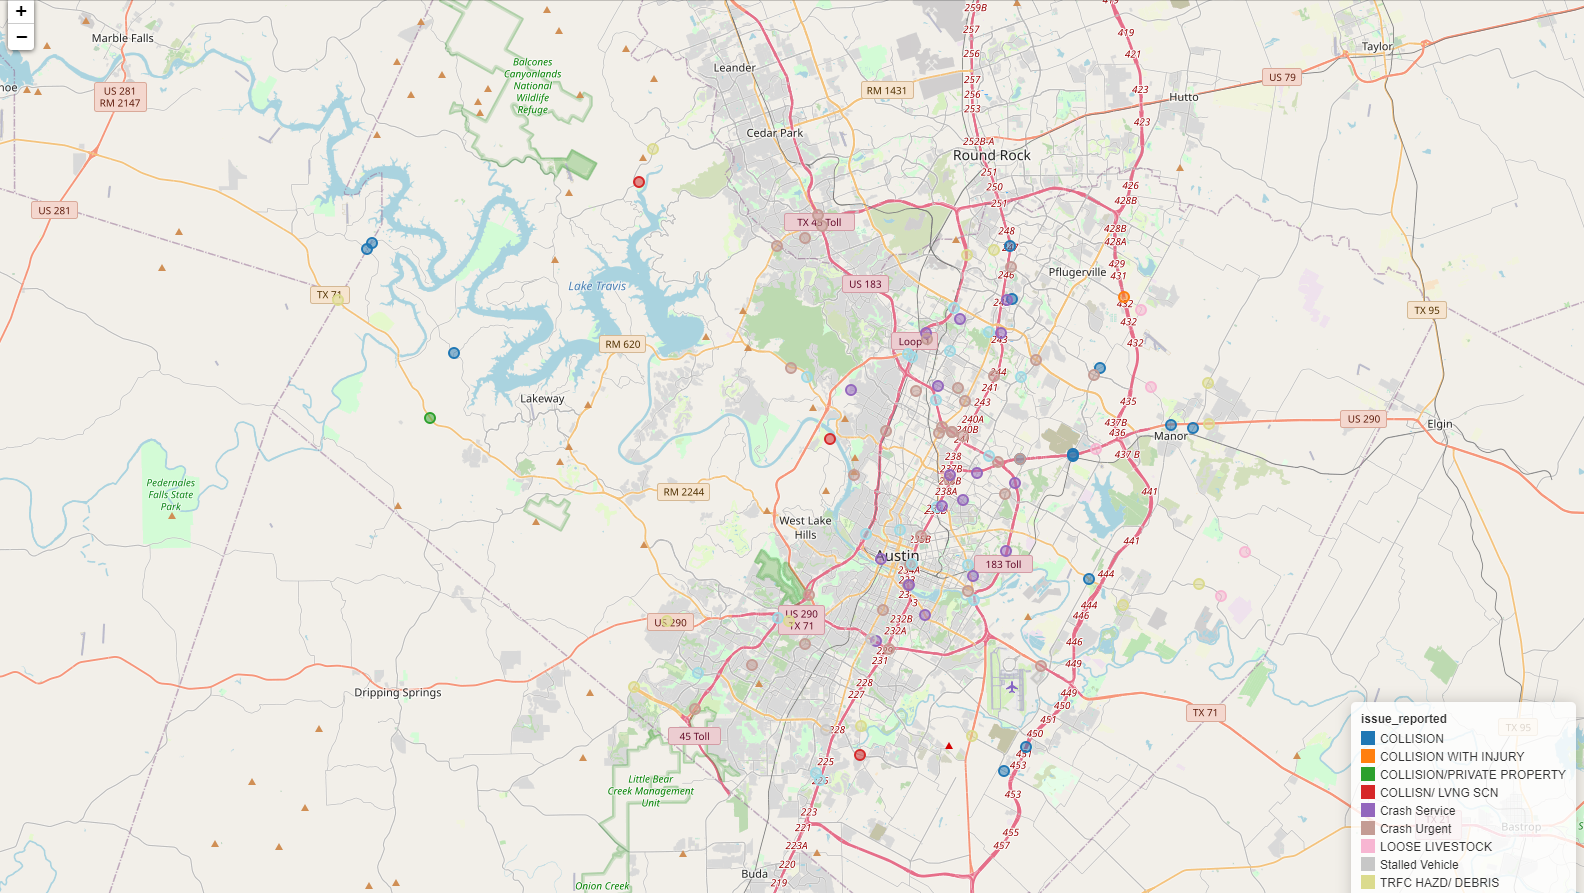

In [4]:
accidents = gdf.drop("published_date", axis =1)

accidents.explore(column='issue_reported', legend=True, marker_kwds=dict(radius=5))

#Visualization will not show on GitHub
%matplotlib inline
Image("Z:\Clases\CLASE\Master Rochester\Fall_2022\InterviewPrep\ReadAustinData\Images\Accidens_Points.png")

#### Accidents today - ZIP code Level

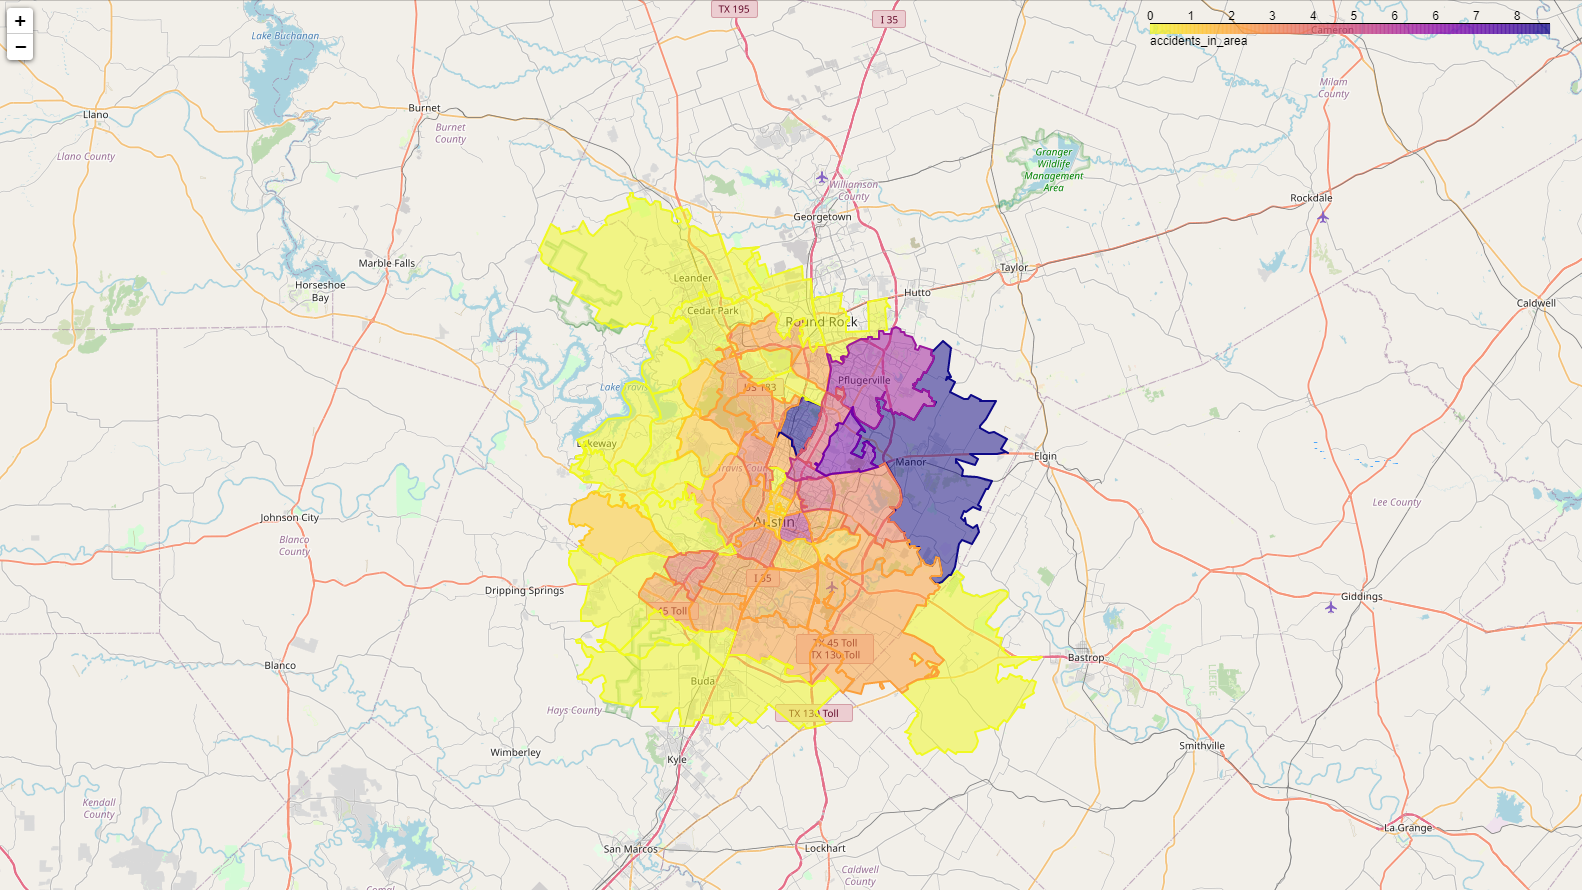

In [5]:
# Lamda function for intersecction
f = lambda x:np.sum(accidents.intersects(x))
Austin_zips["accidents_in_area"] = Austin_zips['geometry'].apply(f)

#Display intersections
Austin_zips.explore(column='accidents_in_area', legend=True, cmap  = "plasma_r")

# #Visualization will not show on GitHub
%matplotlib inline
Image("Z:\Clases\CLASE\Master Rochester\Fall_2022\InterviewPrep\ReadAustinData\Images\zip_accidents.png")

# HotSpots and ColdSpots

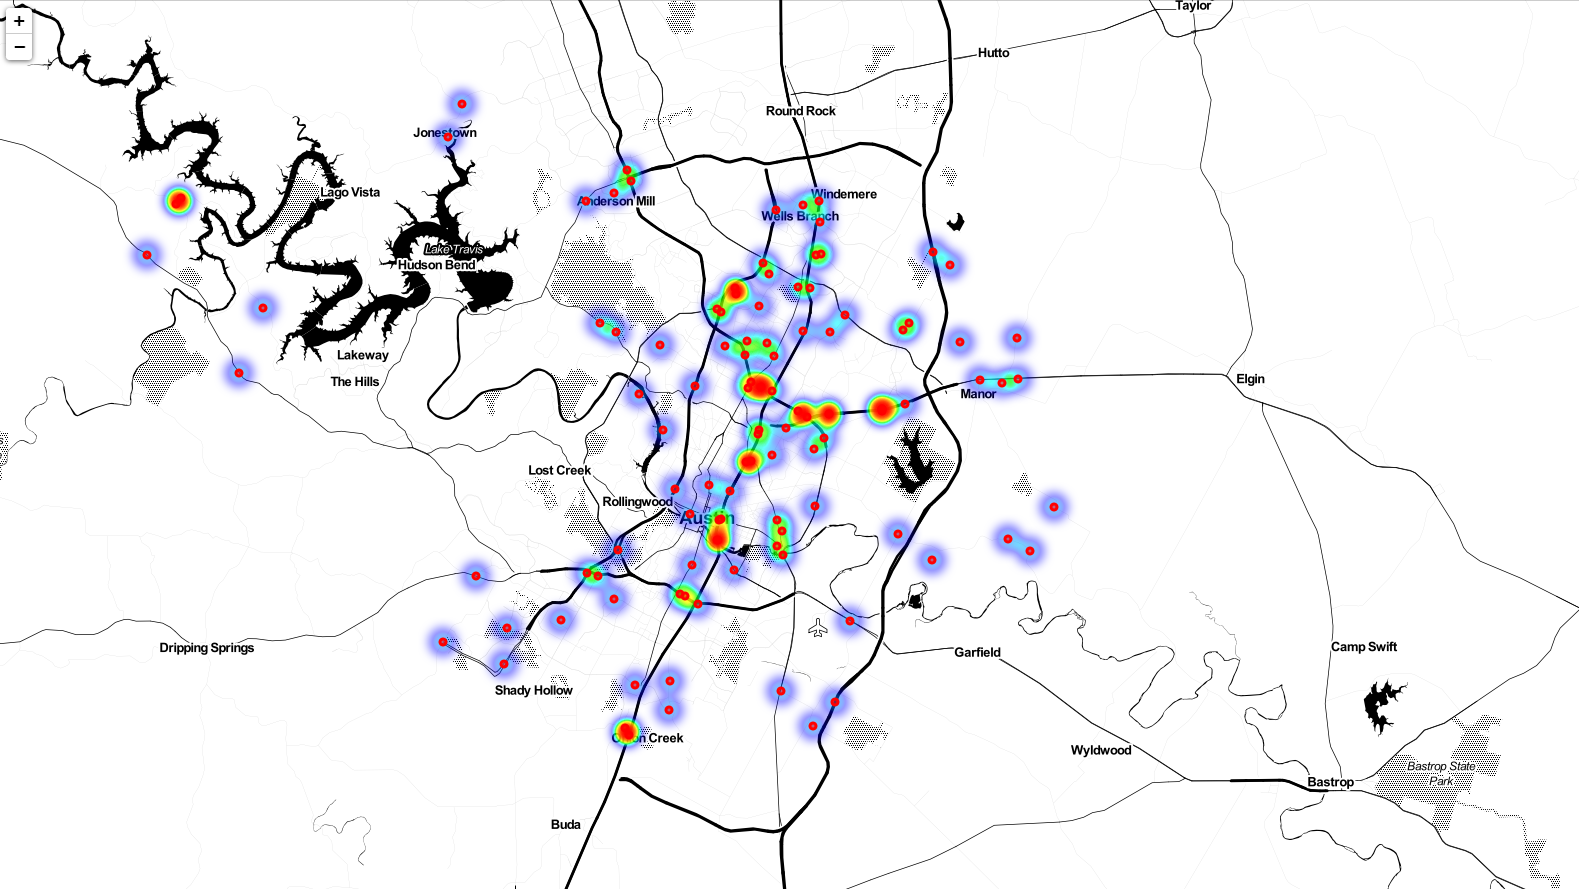

In [6]:
#Center the map in Austin 30.292673,-97.685967
Austin = folium.Map(location=[30.292673,-97.685967], tiles='Stamen Toner', zoom_start=10.5)

#Add Data to the map from the intial pandas dataframe (today)
for i,row in today.iterrows():
    folium.CircleMarker((row.latitude,row.longitude), radius=3, weight=3, color='red', fill_color='red', fill_opacity=.5).add_to(Austin)

#Create heatmap
Austin.add_child(plugins.HeatMap(data=today[['latitude', 'longitude']], radius=15, blur=10, name = "HotSpots and ColdSpots of Accidents in Austin"))

#Plot Map
Austin

# #Visualization will not show on GitHub
%matplotlib inline
Image("Z:\Clases\CLASE\Master Rochester\Fall_2022\InterviewPrep\ReadAustinData\Images\hotspots.png")

# TIME-SERIES ANALYSIS

In [7]:
results_df.head(2)

,traffic_report_id,published_date,issue_reported,location,latitude,longitude,address,traffic_report_status,traffic_report_status_date_time
303389,73121A89C6113B175EE083B001A5175876D2B470_16713...,2022-12-18 04:28:03+00:00,Crash Urgent,"(30.389249,-97.745767)",30.389249,-97.745767,9800-9832 Research Blvd Svrd Sb,ACTIVE,2022-12-18T04:35:03.000Z
303388,0311E1791C1FE92ECD3215FA0472BCE6BF2B252D_16713...,2022-12-18 04:25:05+00:00,Crash Service,"(30.3123,-97.708464)",30.3123,-97.708464,5355 N Ih 35 Svrd Nb,ACTIVE,2022-12-18T04:30:03.000Z


In [8]:
print("Total number of accidents: ", results_df.shape[0])

Total number of accidents:  303391


Transform timestamp string to time format

In [9]:
results_df['date'] =  pd.to_datetime(results_df['traffic_report_status_date_time'], format='%Y-%m-%dT%H:%M:%S.%f')#convert date time in dataframe
results_df = results_df.drop(columns = ["traffic_report_status_date_time"]) #drop old time column
results_df = results_df[results_df["date"].dt.year != 1970] #we have a data point from 1970 (outlier)
results_df.info() #verify time transformation

<class 'pandas.core.frame.DataFrame'>
Int64Index: 303390 entries, 303389 to 40484
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype              
---  ------                 --------------   -----              
 0   traffic_report_id      303390 non-null  object             
 1   published_date         303390 non-null  datetime64[ns, UTC]
 2   issue_reported         303390 non-null  object             
 3   location               303390 non-null  object             
 4   latitude               303311 non-null  object             
 5   longitude              303311 non-null  object             
 6   address                303390 non-null  object             
 7   traffic_report_status  301697 non-null  object             
 8   date                   303390 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](2), object(7)
memory usage: 23.1+ MB


## Timeseries Visualization Across the Entire Dataset

In [10]:
#https://carto.com/blog/predicting-traffic-accident-hotspots-with-spatial-data-science/

<AxesSubplot:title={'center':'Accidents in a Single Day '}, xlabel='date', ylabel='Cummulative Accidents'>

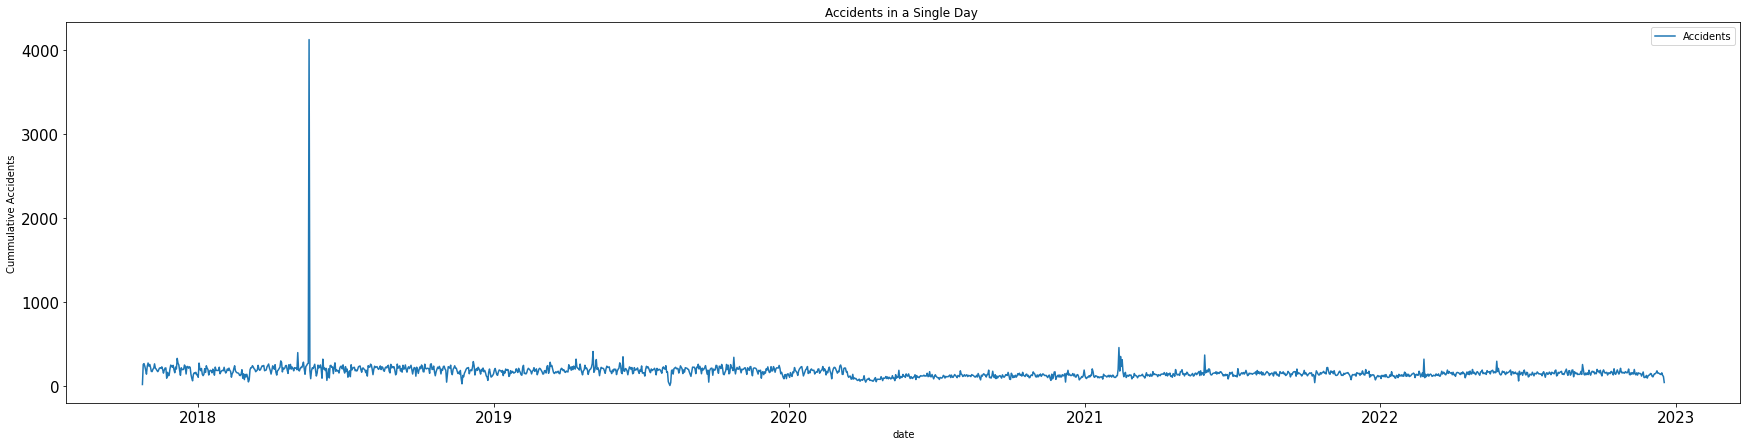

In [11]:
accidents_single_day = results_df.groupby(results_df['date'].dt.date).count().rename(columns={"date":"Accidents"}).Accidents
accidents_single_day.plot(figsize=(30,7), title="Accidents in a Single Day ", ylabel="Cummulative Accidents", fontsize = 15, legend = True)

<AxesSubplot:title={'center':'Accidents in a Single Day (Remove Outliers) '}, xlabel='date', ylabel='Cummulative Accidents'>

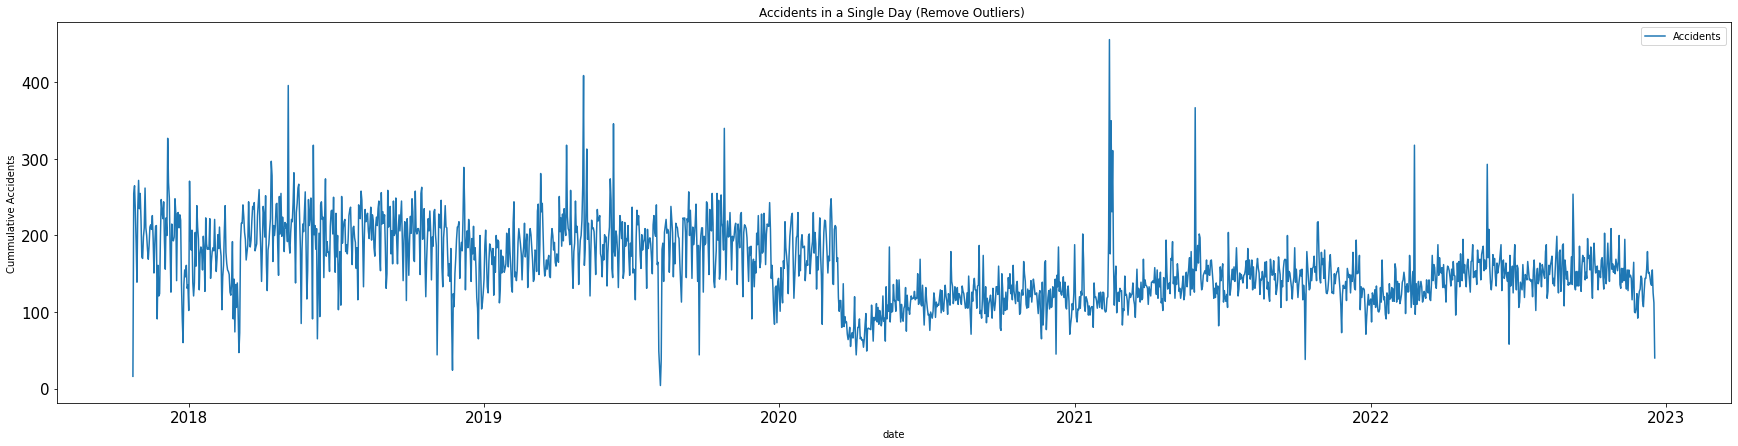

In [12]:
#Remove extreme outlier for visualization purposes
(accidents_single_day[accidents_single_day < 1000]).plot(figsize=(30,7), title="Accidents in a Single Day (Remove Outliers) ", 
                                                            ylabel="Cummulative Accidents", fontsize = 15, legend = True)

### Per Month (2021)

Text(0, 0.5, 'Number of accidents')

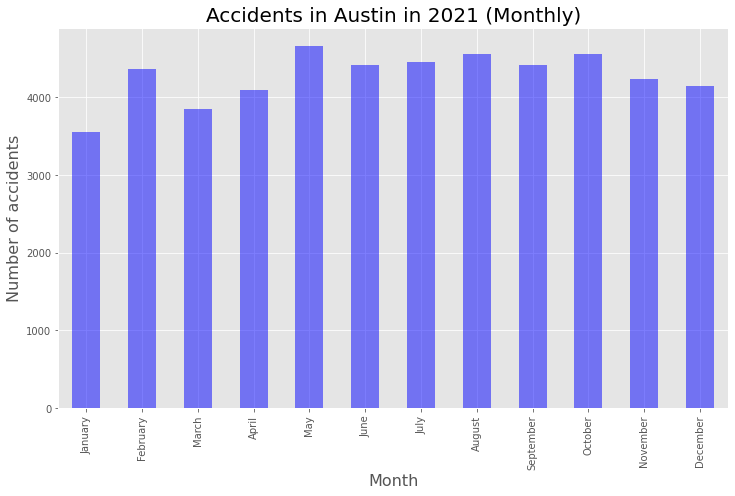

In [13]:
# Number of accident per month
accidents_month = results_df[results_df['date'].dt.year == 2021].groupby(results_df['date'].dt.month).count().date

# Replace the month integers by month names.
accidents_month.index=[calendar.month_name[x] for x in range(1,13)]

plt.style.use('ggplot')

# plot accidents per month
accidents_month.plot(kind='bar',figsize=(12,7), color='blue', alpha=0.5)

# # title and x,y labels
plt.title('Accidents in Austin in 2021 (Monthly)', fontsize=20)
plt.xlabel('Month',fontsize=16)
plt.ylabel('Number of accidents',fontsize=16)

### Per Day 2021

Text(0, 0.5, 'Number of accidents')

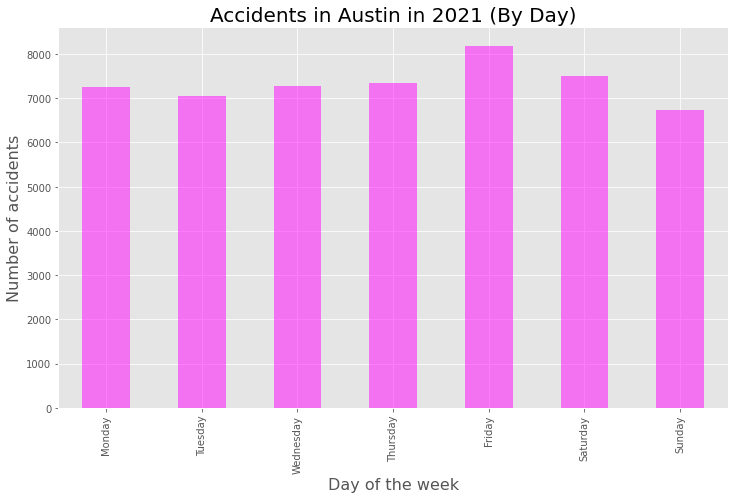

In [14]:
# Number of accident per day of the week
accidents_day = results_df[results_df['date'].dt.year == 2021].groupby(results_df['date'].dt.dayofweek).count().date

# Replace the day integers by day names.
accidents_day.index=[calendar.day_name[x] for x in range(0,7)]

# plot accidents per day
accidents_day.plot(kind='bar',figsize=(12,7), color='magenta', alpha=0.5)

# title and x,y labels
plt.title('Accidents in Austin in 2021 (By Day)', fontsize=20)
plt.xlabel('Day of the week',fontsize=16)
plt.ylabel('Number of accidents',fontsize=16)

### Per hour 2021

Text(0, 0.5, 'Number of accidents')

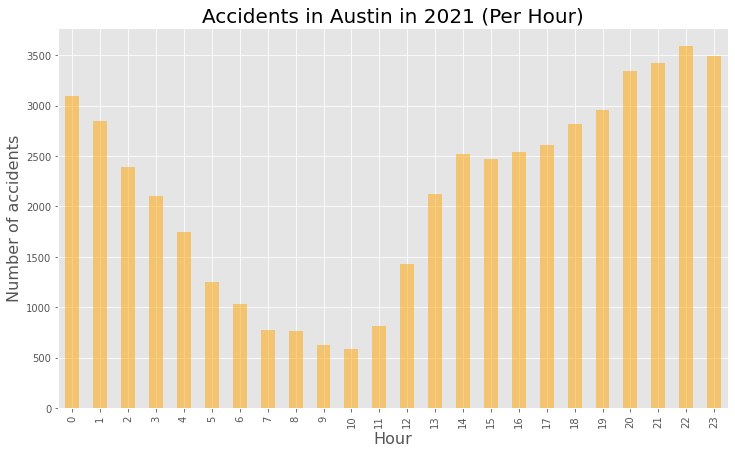

In [15]:
# Number of accident per hour
accidents_hour = results_df[results_df['date'].dt.year == 2021].groupby(results_df['date'].dt.hour).count().date

# plot accidents per hour
accidents_hour.plot(kind='bar',figsize=(12,7), color='orange', alpha=0.5)

# title and x,y labels
plt.title('Accidents in Austin in 2021 (Per Hour)', fontsize=20)
plt.xlabel('Hour',fontsize=16)
plt.ylabel('Number of accidents',fontsize=16)